In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'SEK=X'
numbers_in_currency = 'SEK'
share_name = 'BOL.ST'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,9287,-8179,1108,615,544,1380,7384,10646,0,...,3424,0,3036,8122,4578,18233,1447,-719,273.0,2014-10-20
1,2014-12-31,9615,-8109,1506,835,865,1344,7885,11570,0,...,3764,0,2845,8823,4819,19898,2105,-1001,273.0,2015-02-09
2,2015-03-31,10406,-8892,1514,895,683,1629,8952,12446,0,...,3928,0,3151,9352,4217,19805,725,-705,273.0,2015-04-25
3,2015-06-30,10373,-8927,1446,810,689,1627,8093,11492,0,...,3629,0,3847,9772,2586,18440,2431,-877,273.0,2015-07-20
4,2015-09-30,9764,-8587,1177,648,947,1506,8427,12017,0,...,3940,0,3129,9612,2670,18394,1832,-879,273.0,2015-10-20


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,3587,98032,10714,0,3776,18167,11723,42021,2392,-3590
37,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,3537,101957,10915,0,2962,18396,11462,38052,6471,-4804
38,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,3561,104189,10664,0,3981,18779,11380,45722,1935,-3444
39,2024-06-30,2024-07-15,273.47,22748,-19555,3194,3610,7059,4789,23509,...,3529,112467,12279,0,7612,24817,12156,52801,4128,-3744
40,2024-09-30,2024-10-21,273.47,22193,-18448,3745,2282,3482,5838,23889,...,3490,111083,12350,0,5473,22440,11337,49516,2734,-3221


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
37,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495
38,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,104189,10664,0,3981,18779,11380,45722,1935,-3444,10.376655
39,2024-06-30,2024-07-15,273.47,22748,-19555,3194,3610,7059,4789,23509,...,112467,12279,0,7612,24817,12156,52801,4128,-3744,10.684878
40,2024-09-30,2024-10-21,273.47,22193,-18448,3745,2282,3482,5838,23889,...,111083,12350,0,5473,22440,11337,49516,2734,-3221,10.423824


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-10-20,273.00,19396,-16953,2443,1357,4219,3711,24137,...,98032,10714,0,3776,18167,11723,42021,2392,-3590,10.805716
37,2023-12-31,2024-02-09,273.00,20754,-18170,2585,1656,4978,3964,21987,...,101957,10915,0,2962,18396,11462,38052,6471,-4804,10.657495
38,2024-03-31,2024-04-22,273.47,18481,-16303,2178,1139,4272,3624,23356,...,104189,10664,0,3981,18779,11380,45722,1935,-3444,10.376655
39,2024-06-30,2024-07-15,273.47,22748,-19555,3194,3610,7059,4789,23509,...,112467,12279,0,7612,24817,12156,52801,4128,-3744,10.684878
40,2024-09-30,2024-10-21,273.47,22193,-18448,3745,2282,3482,5838,23889,...,111083,12350,0,5473,22440,11337,49516,2734,-3221,10.423824


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-10-20,77.660461,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.562621,0.437379,0.0,0.0,0.0,0.0,0.119307,0.066222,0.0,0.0
1,2014-10-27,82.185028,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.562621,0.437379,0.0,0.0,0.0,0.0,0.119307,0.066222,0.0,0.0
2,2014-11-03,82.320084,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.562621,0.437379,0.0,0.0,0.0,0.0,0.119307,0.066222,0.0,0.0
3,2014-11-10,85.696625,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.562621,0.437379,0.0,0.0,0.0,0.0,0.119307,0.066222,0.0,0.0
4,2014-11-17,86.034302,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.562621,0.437379,0.0,0.0,0.0,0.0,0.119307,0.066222,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-10-20,77.660461,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.0,0.119307,0.066222,0.0,0.0,inf,0.903953,inf,inf,inf
1,2014-10-27,82.185028,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.0,0.119307,0.066222,0.0,0.0,inf,0.956618,inf,inf,inf
2,2014-11-03,82.320084,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.0,0.119307,0.066222,0.0,0.0,inf,0.958190,inf,inf,inf
3,2014-11-10,85.696625,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.0,0.119307,0.066222,0.0,0.0,inf,0.997492,inf,inf,inf
4,2014-11-17,86.034302,2014-09-30,9287.0,0.0,85.912088,273.0,0.0,0.0,544.0,...,0.0,0.119307,0.066222,0.0,0.0,inf,1.001423,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

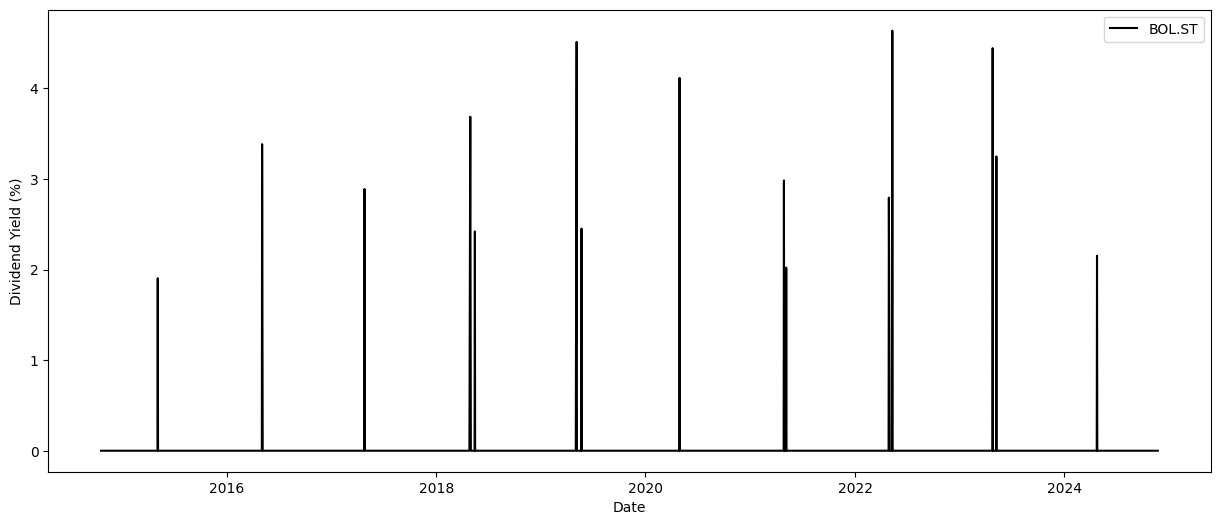

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.684838
share_price      1.000000
Name: share_price, dtype: float64


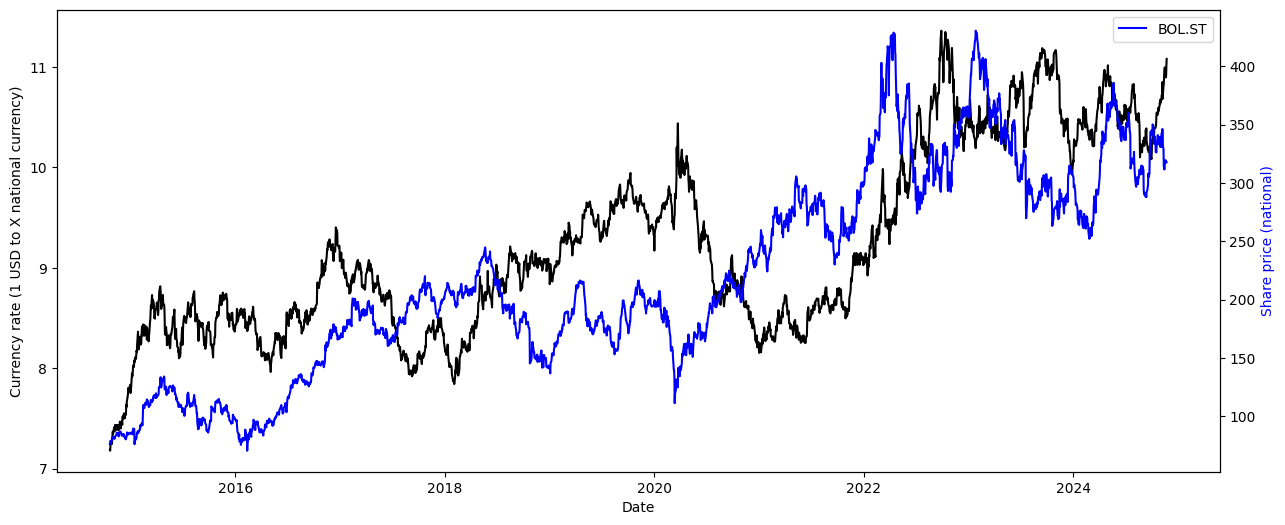

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

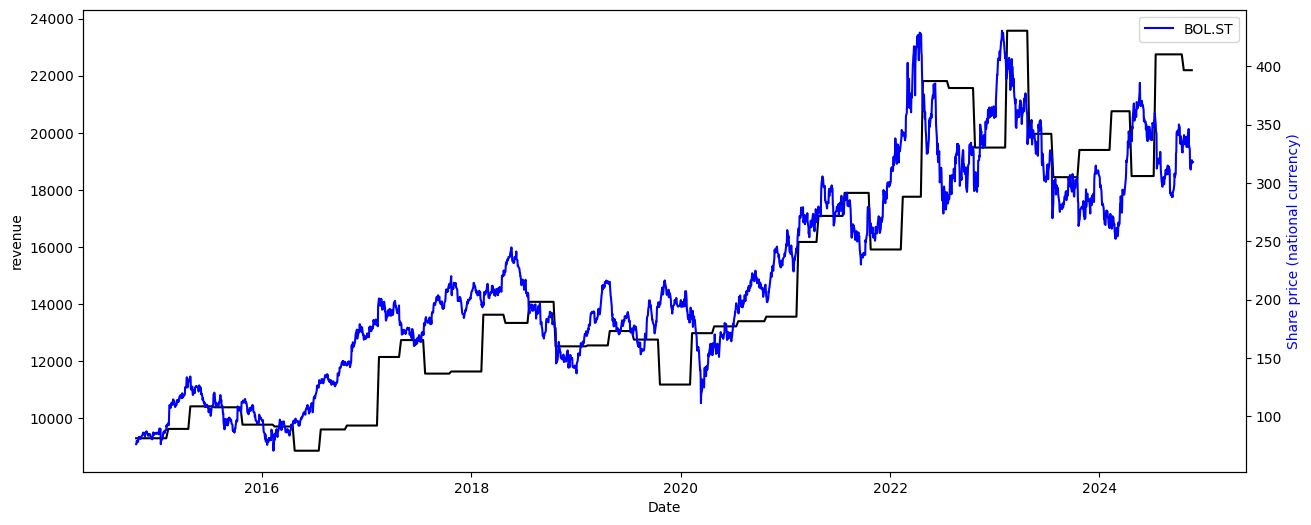

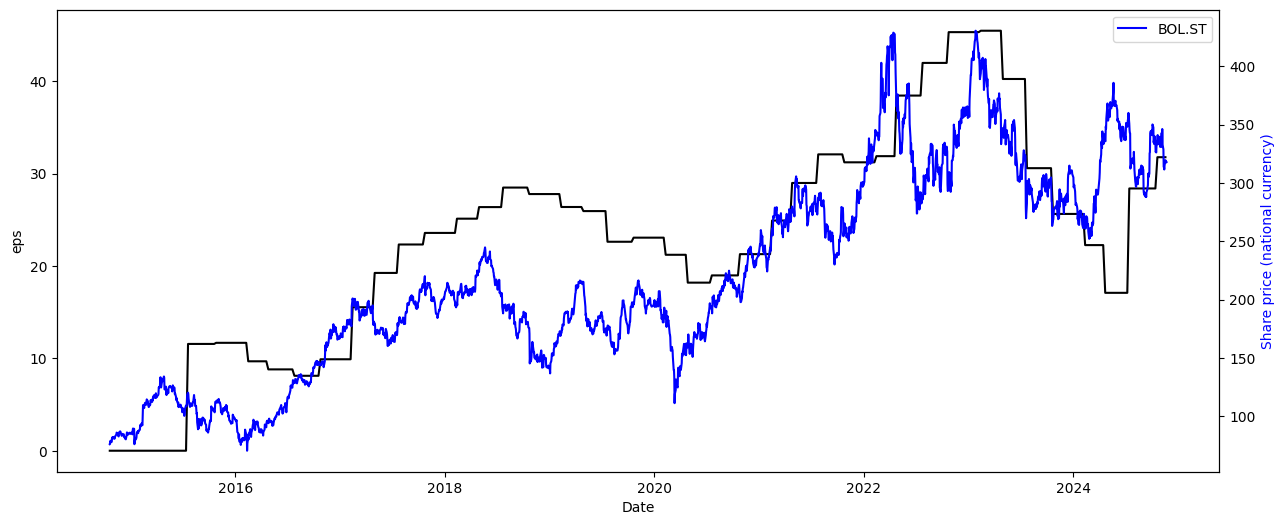

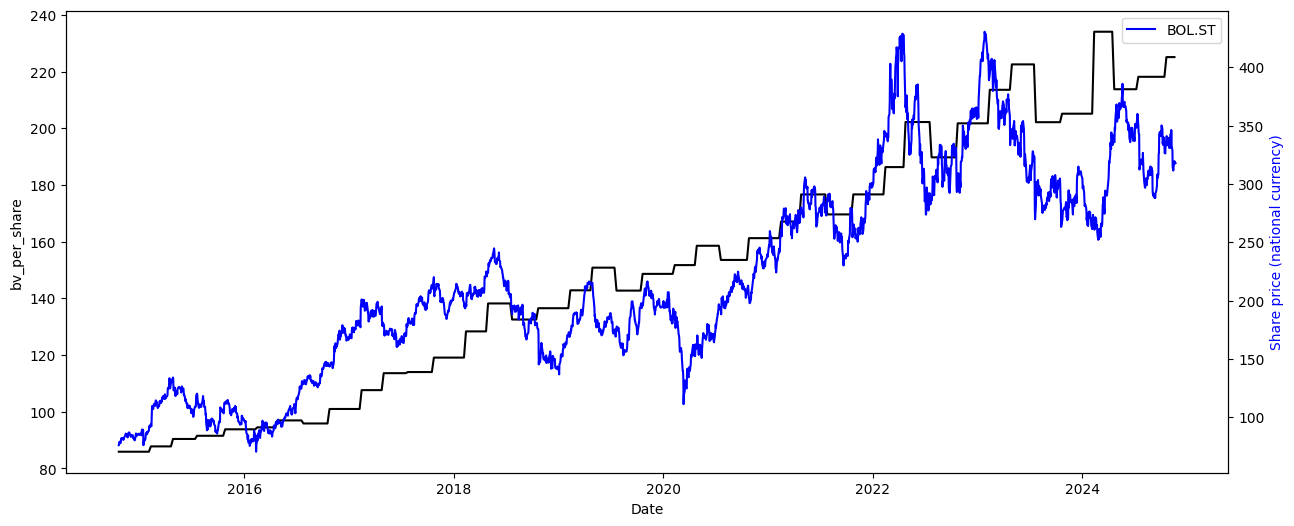

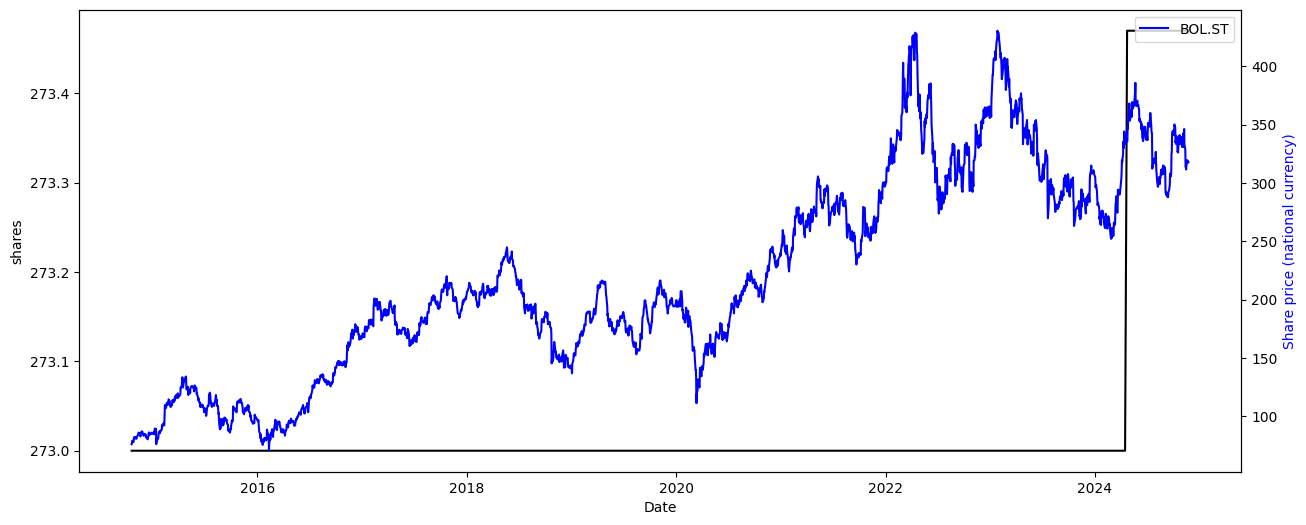

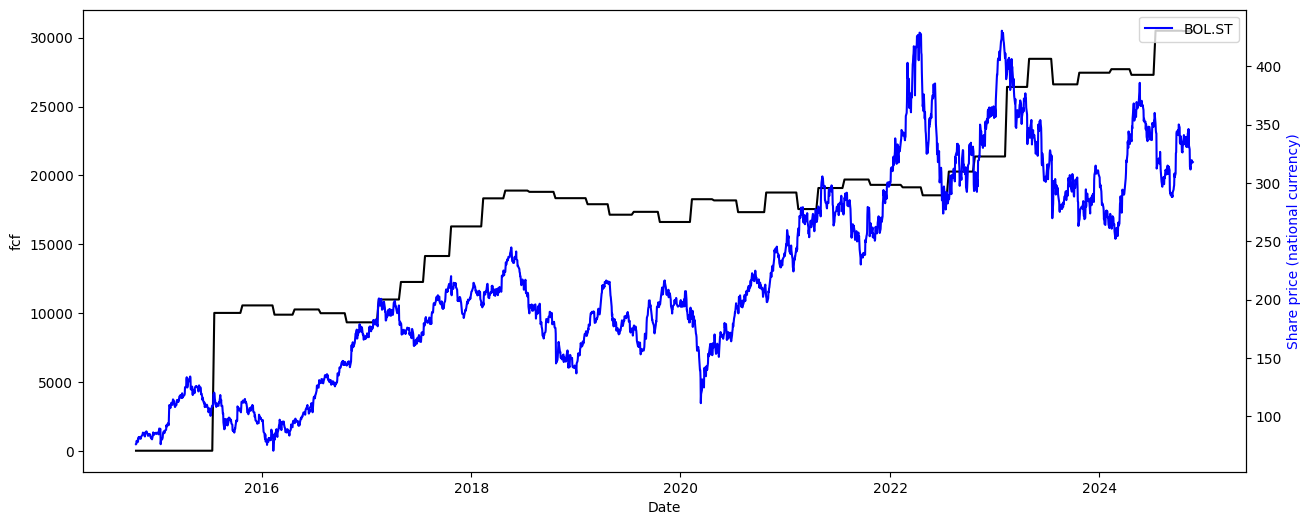

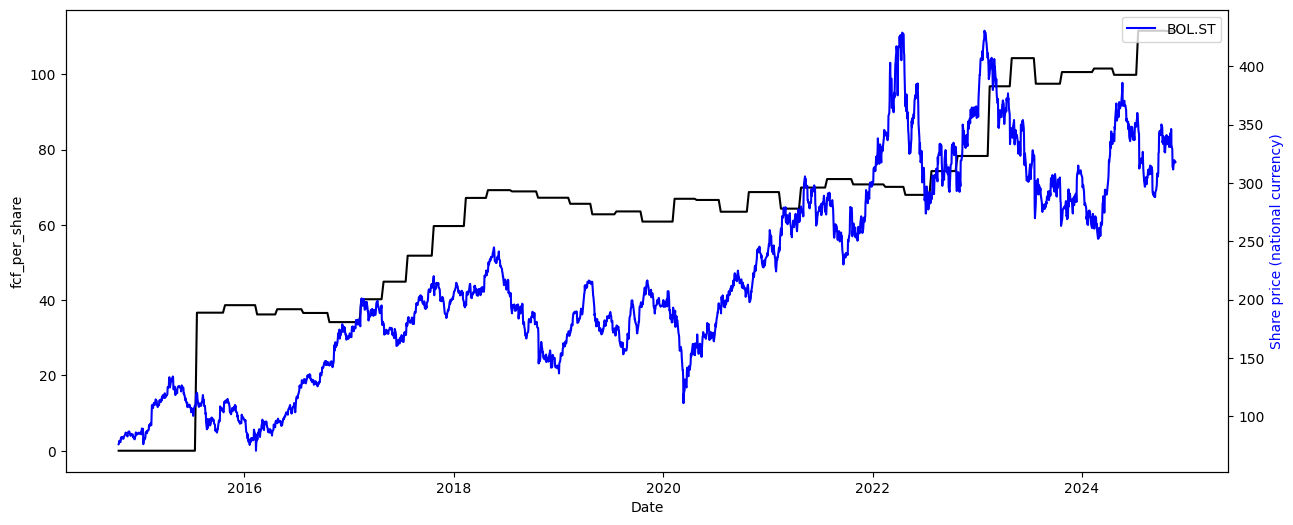

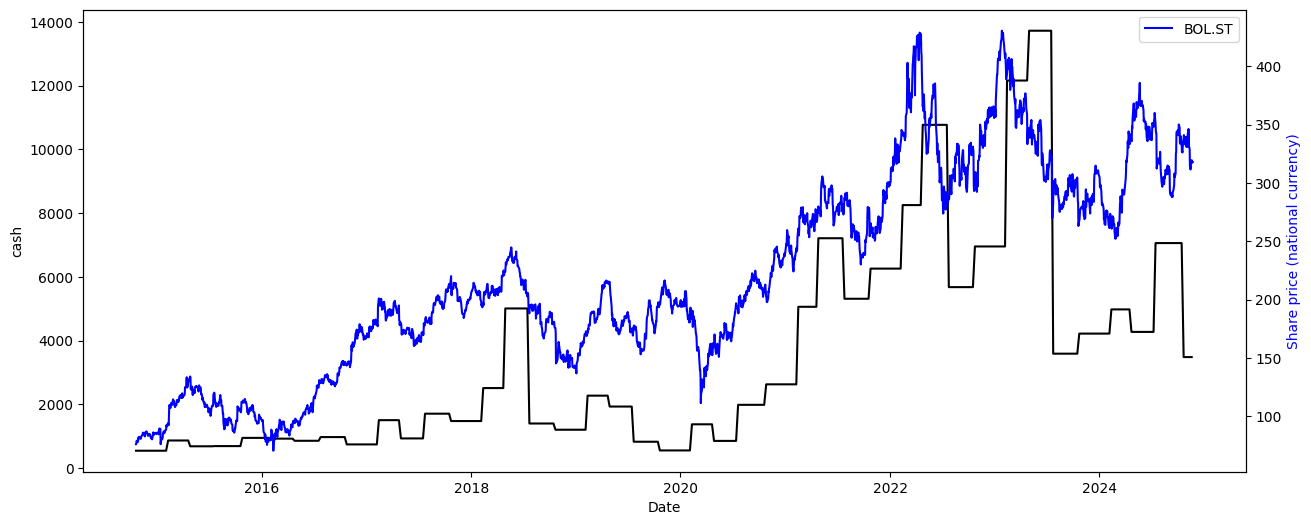

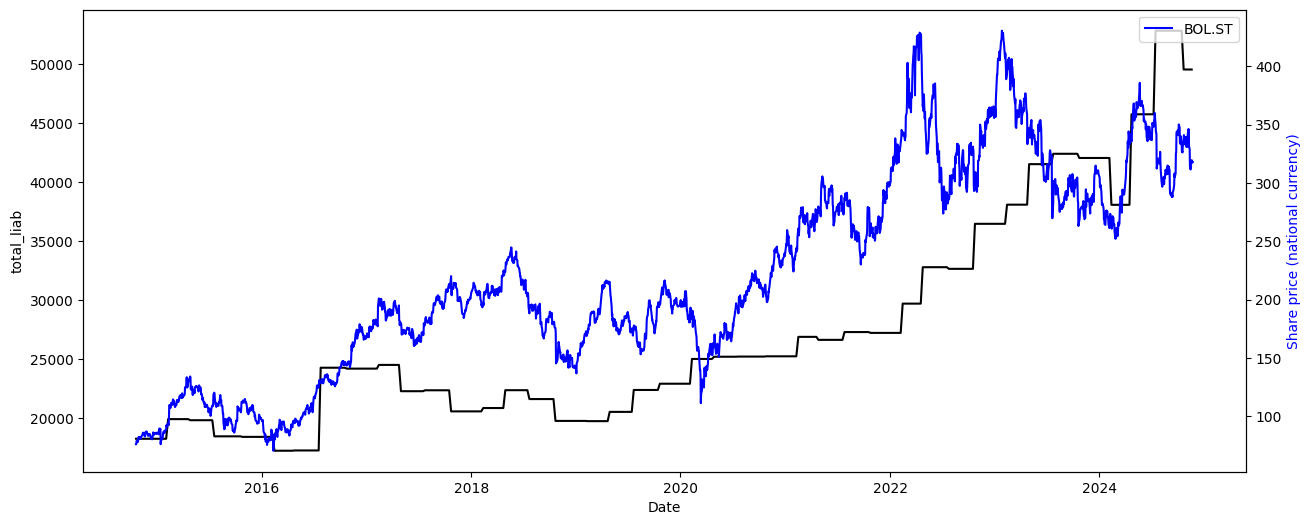

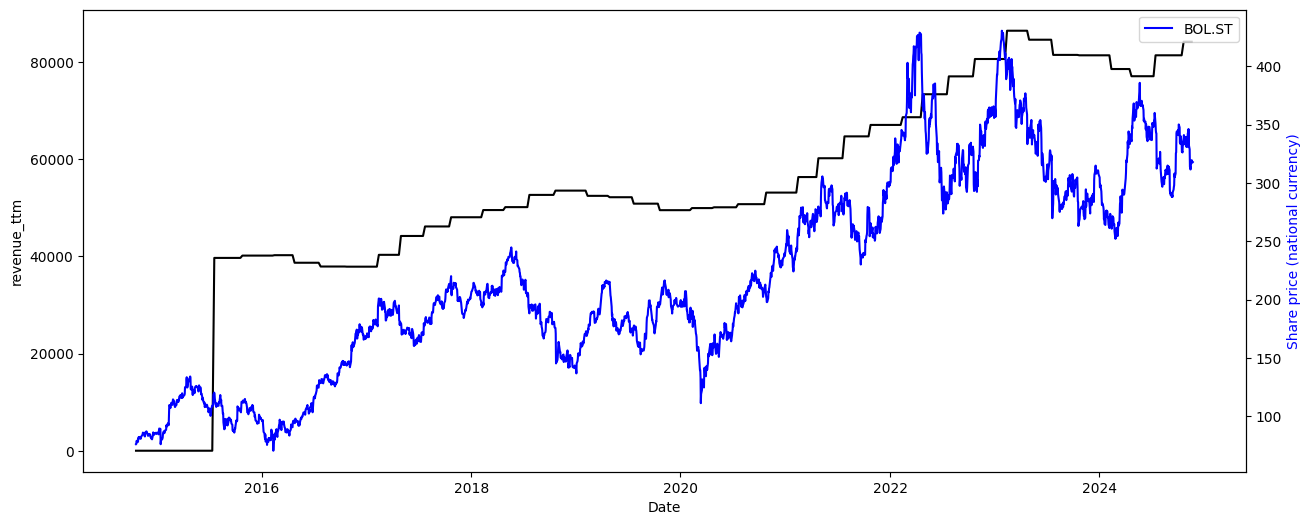

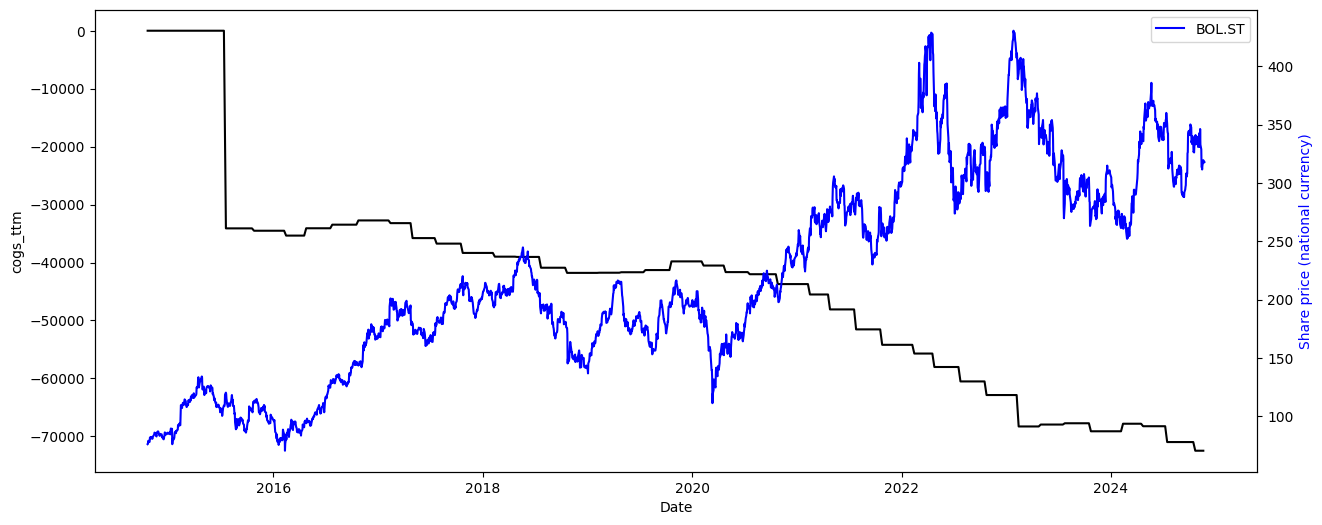

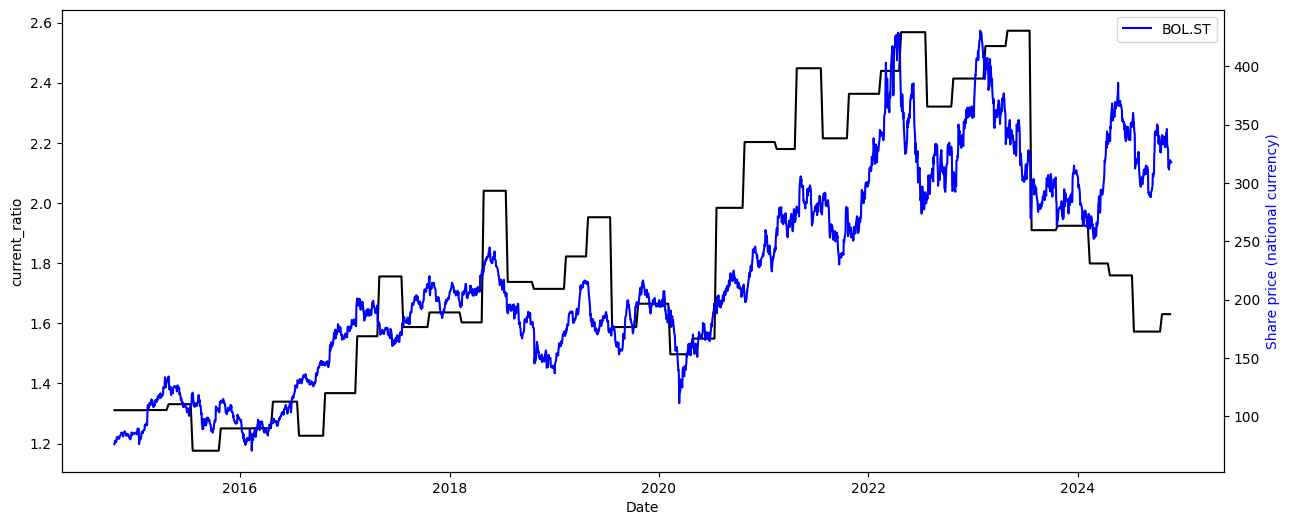

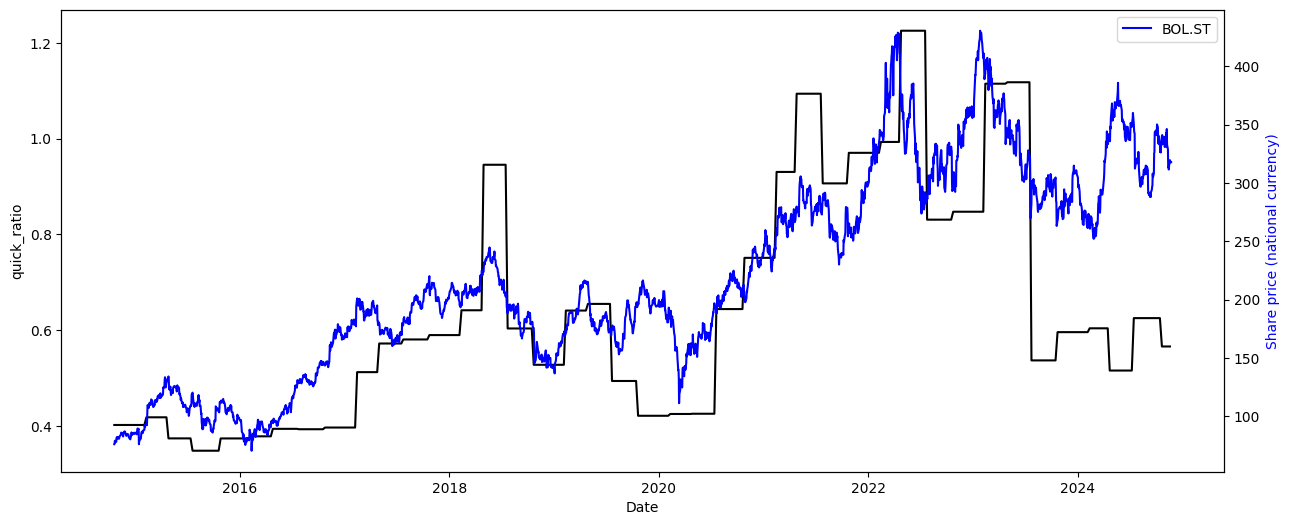

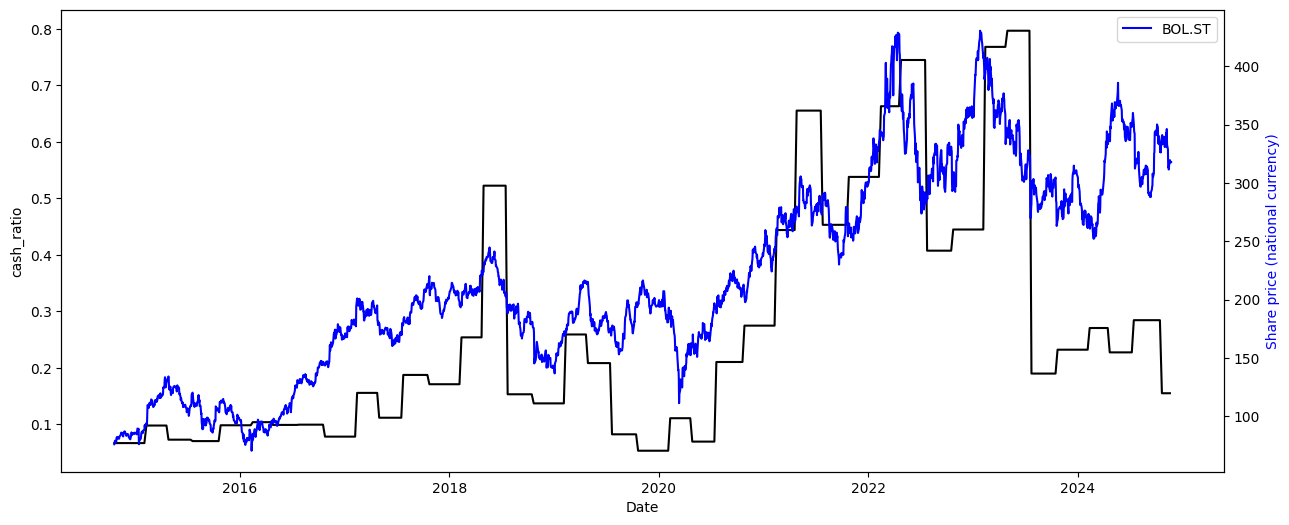

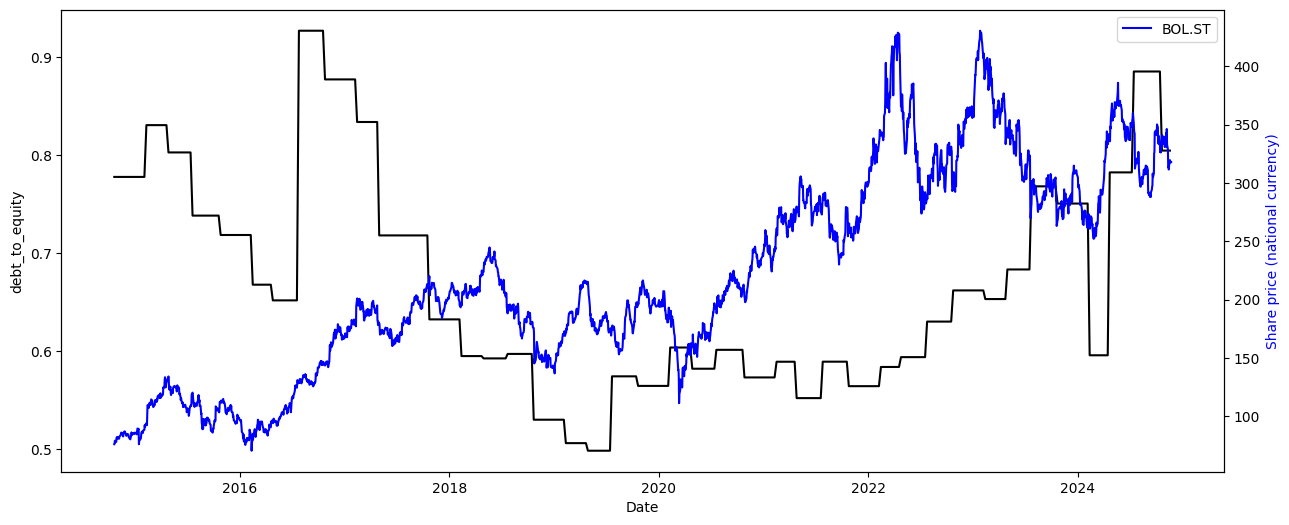

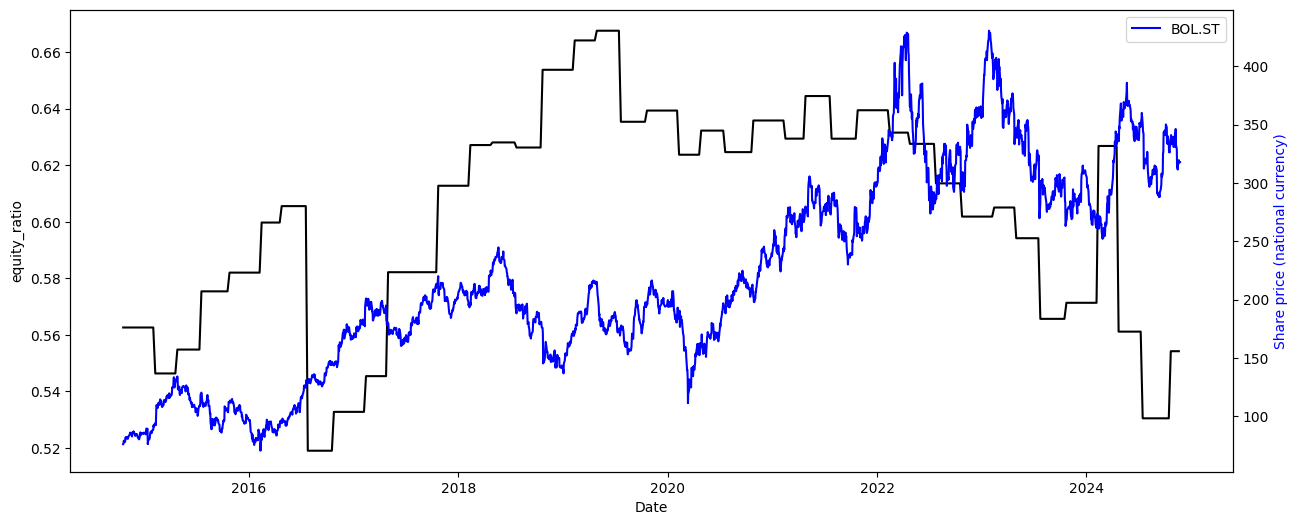

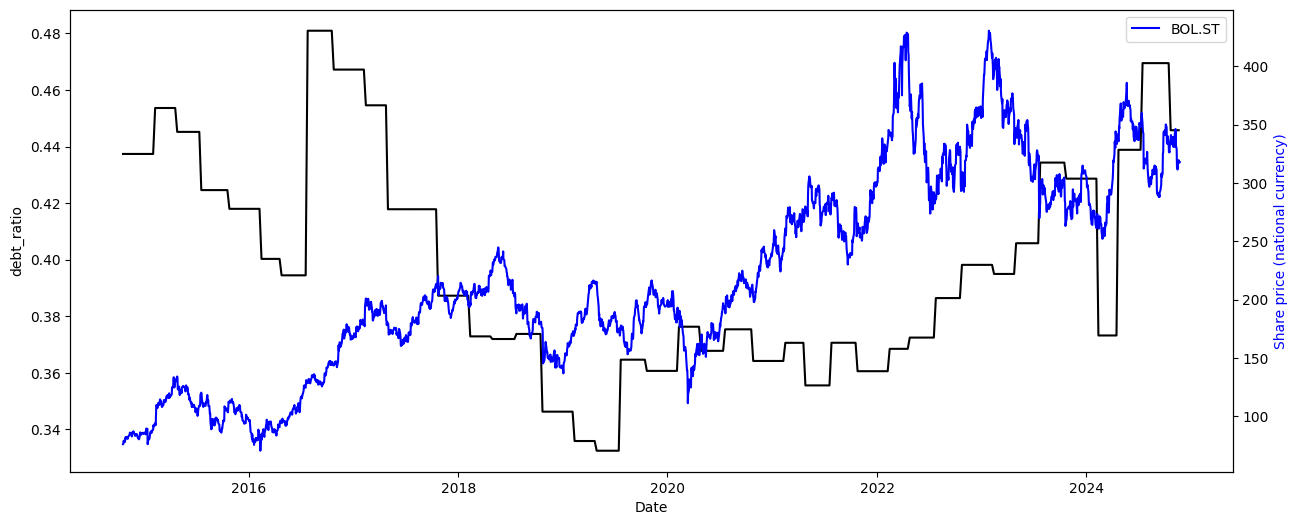

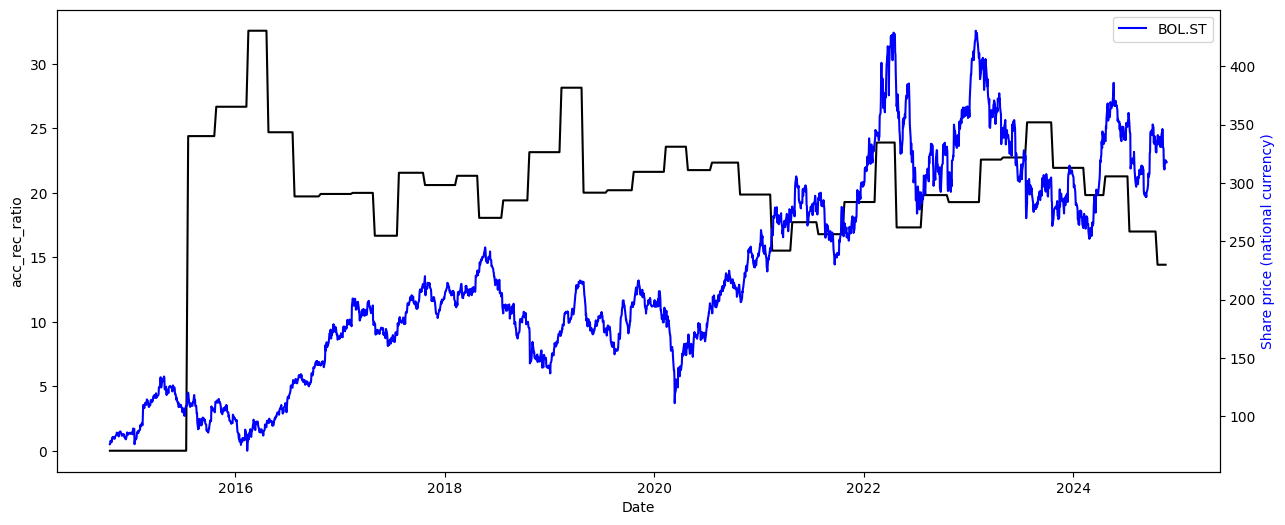

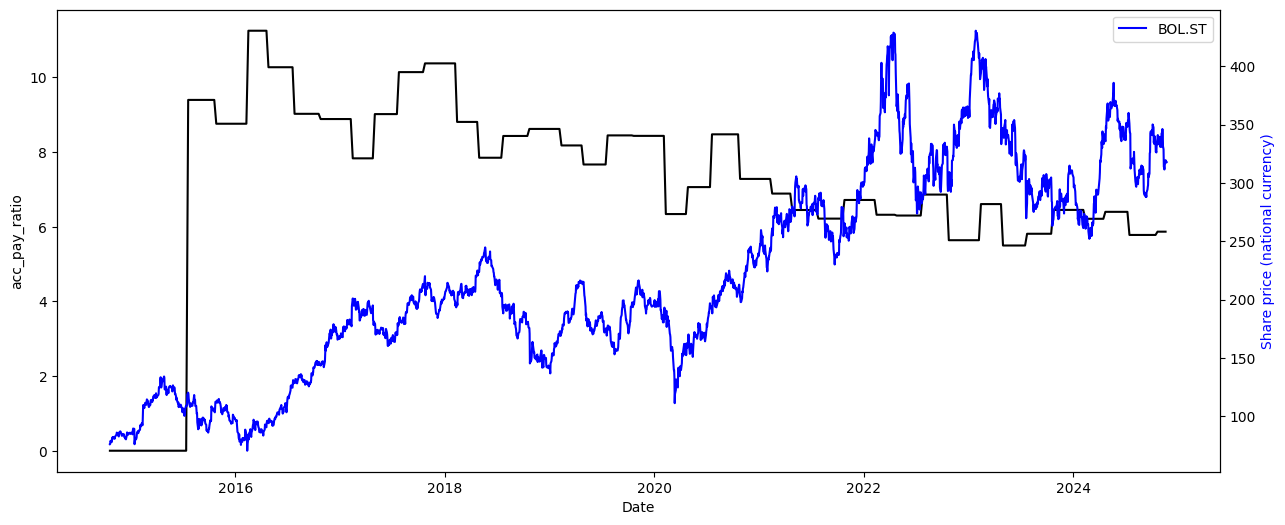

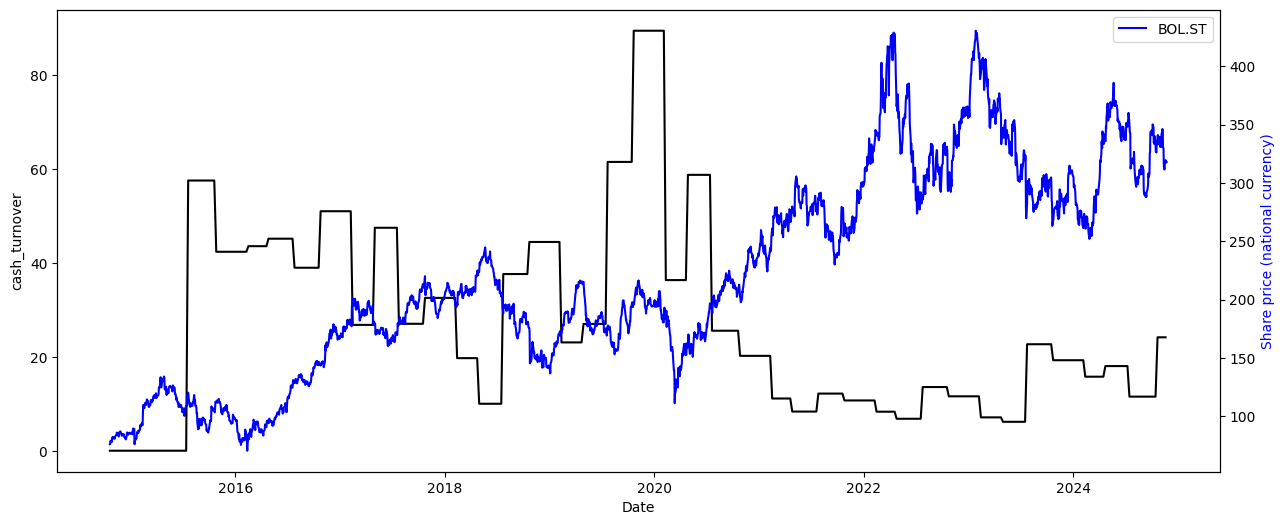

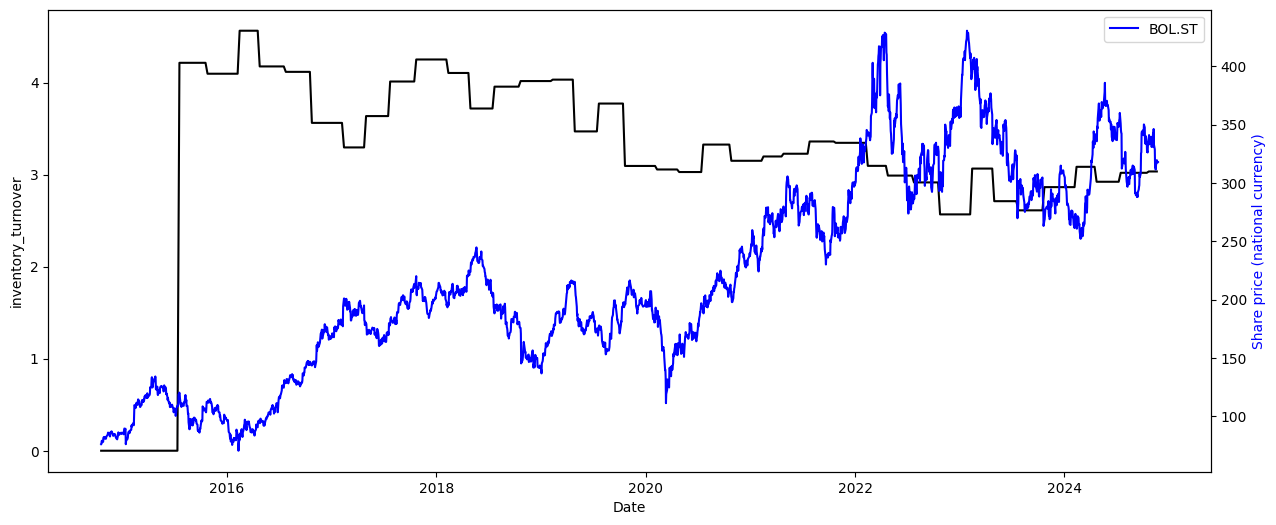

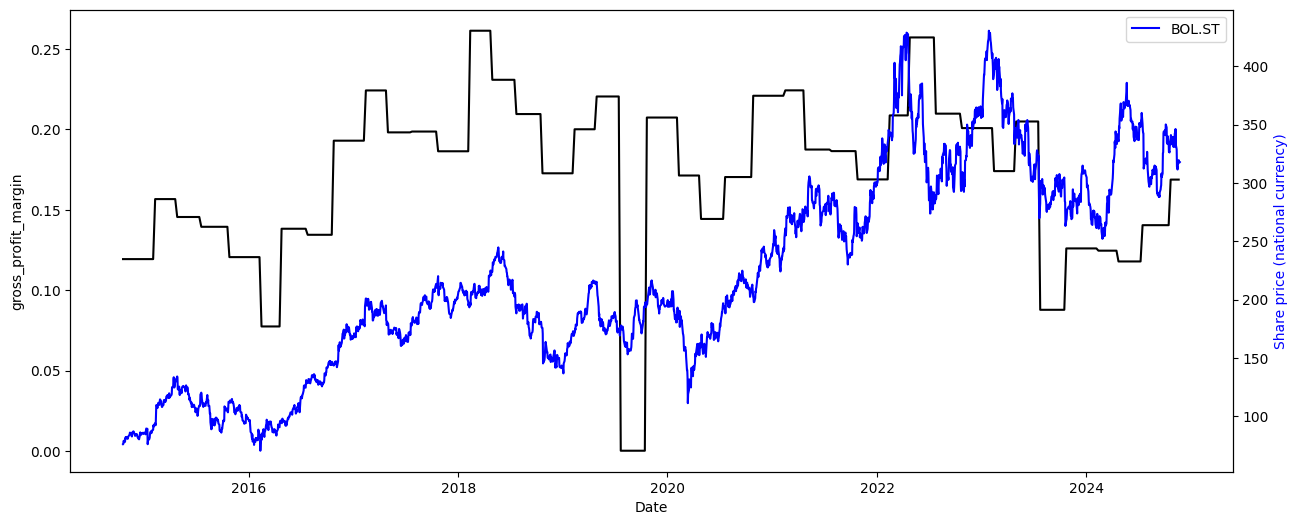

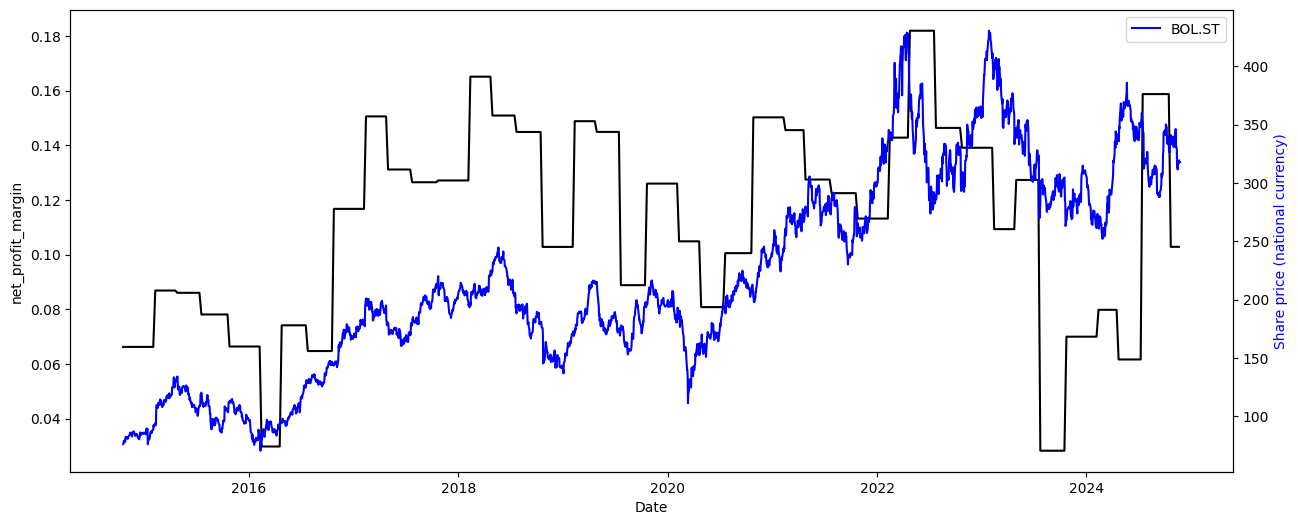

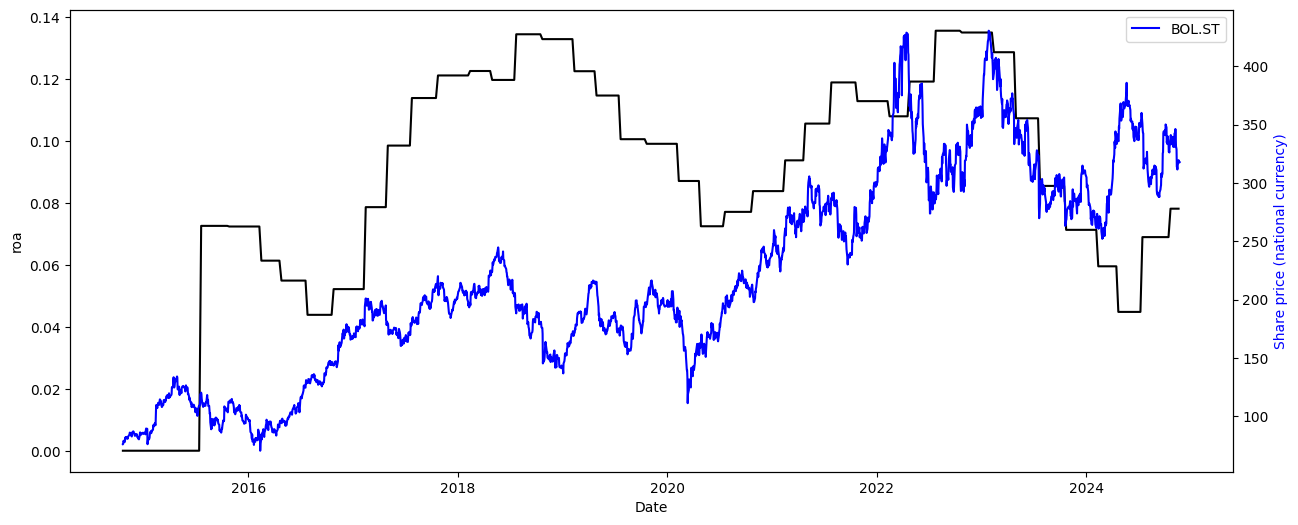

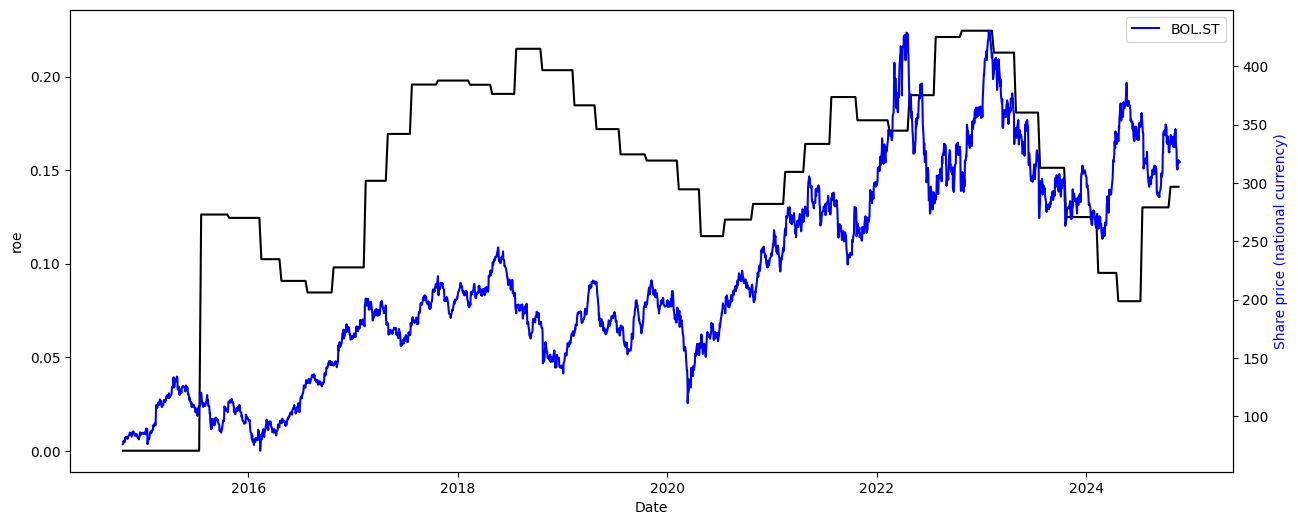

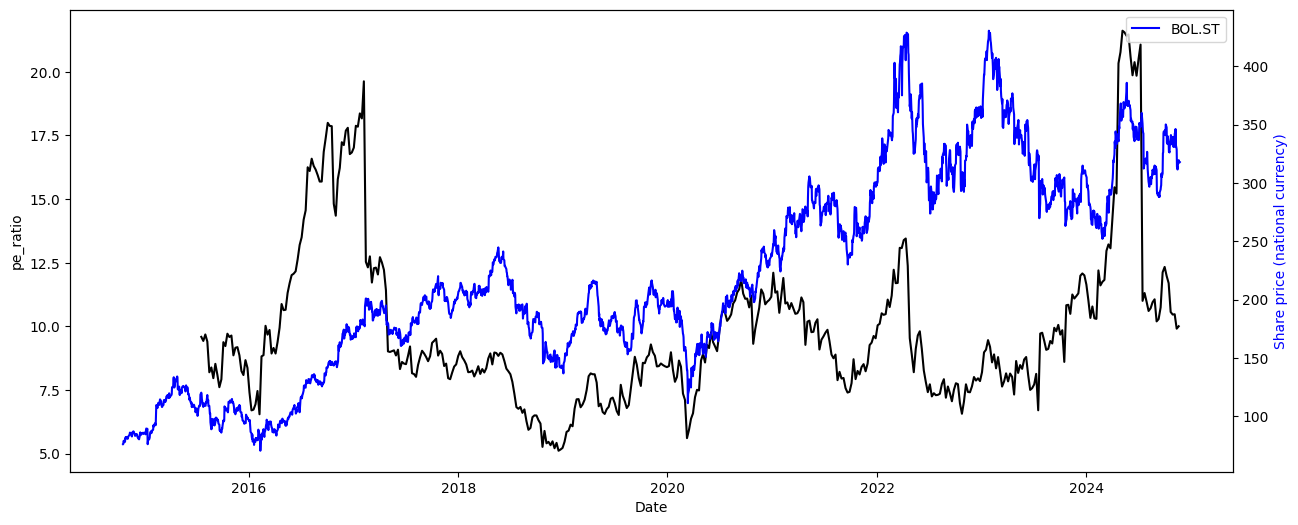

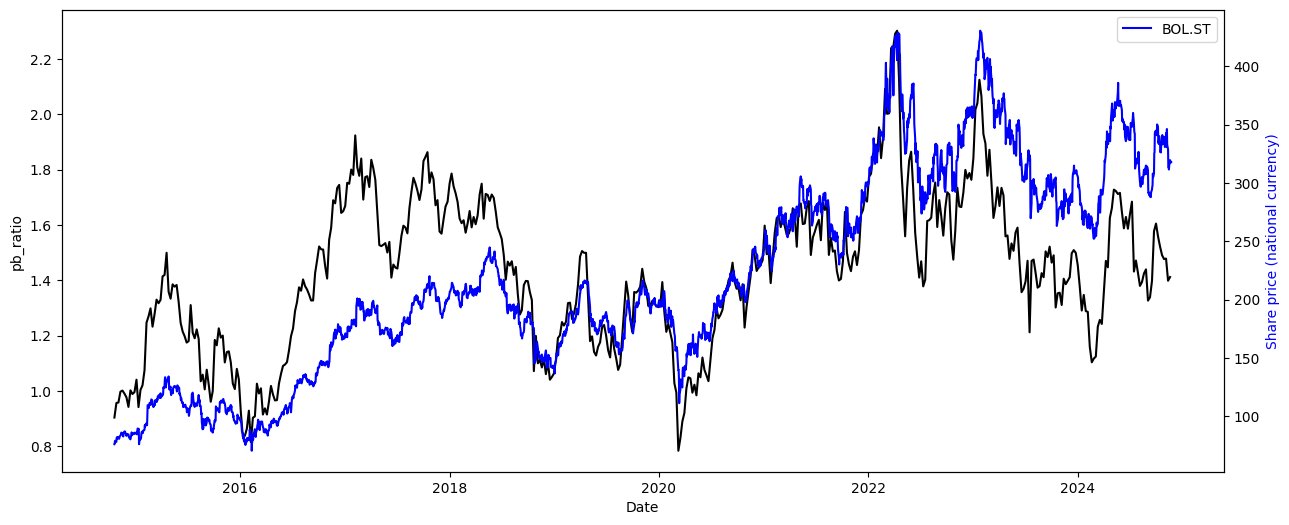

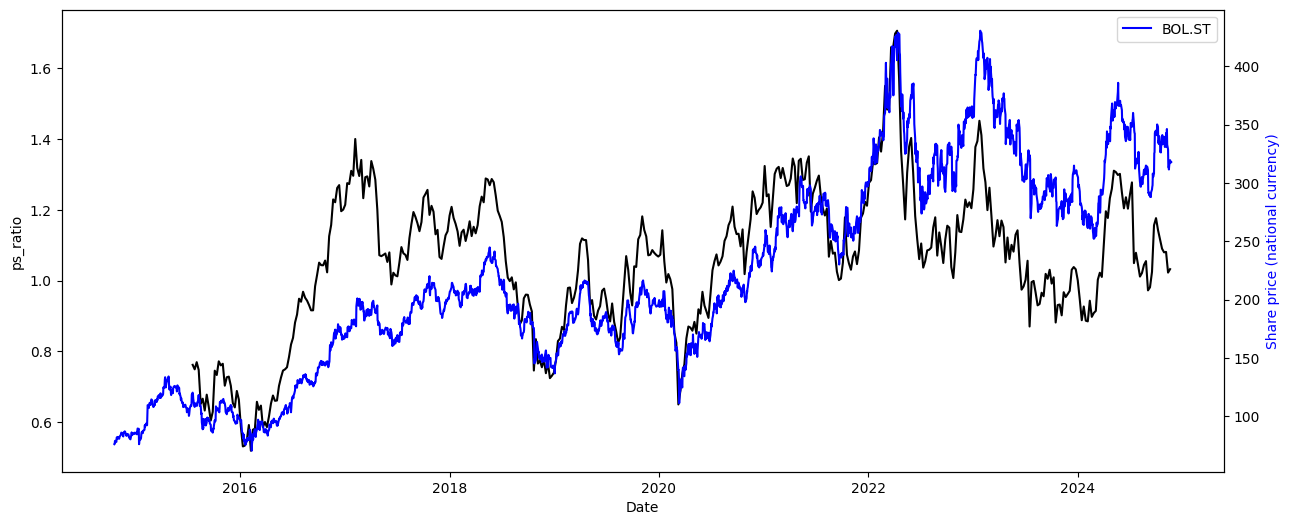

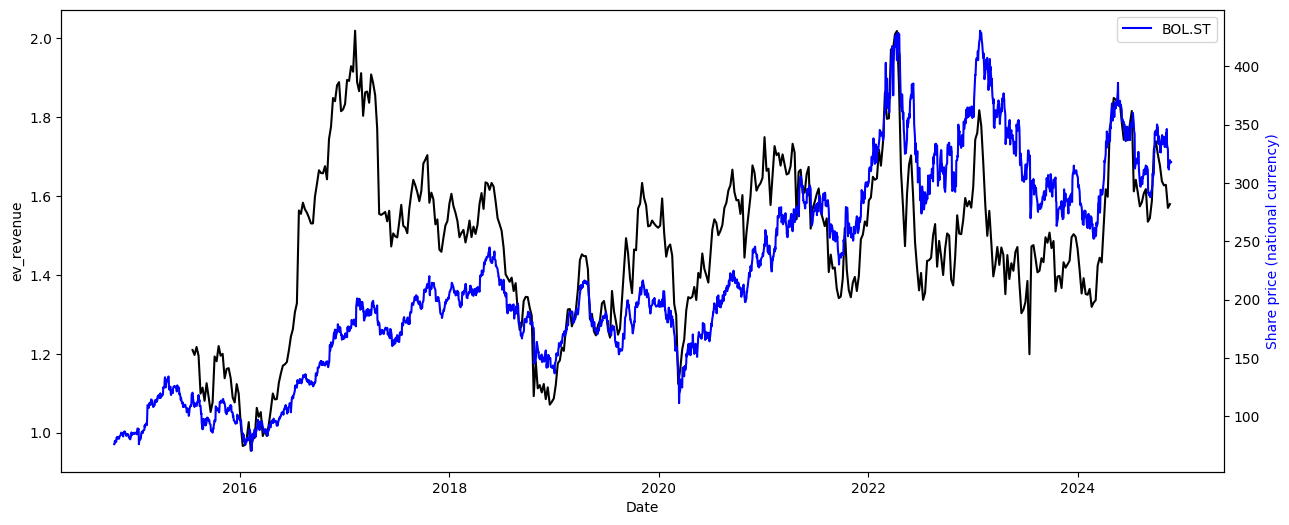

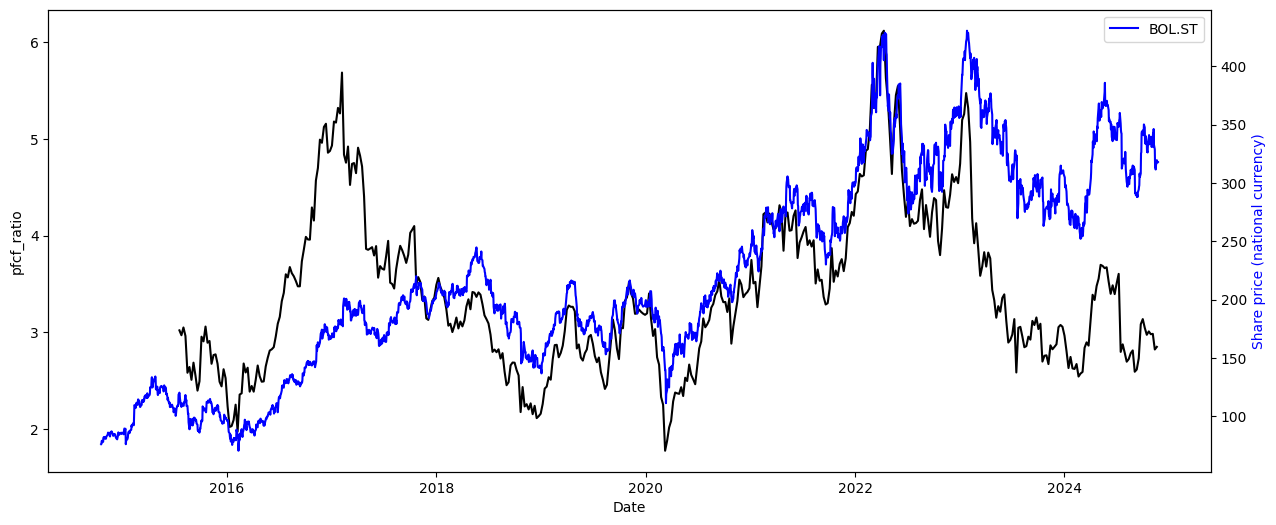

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

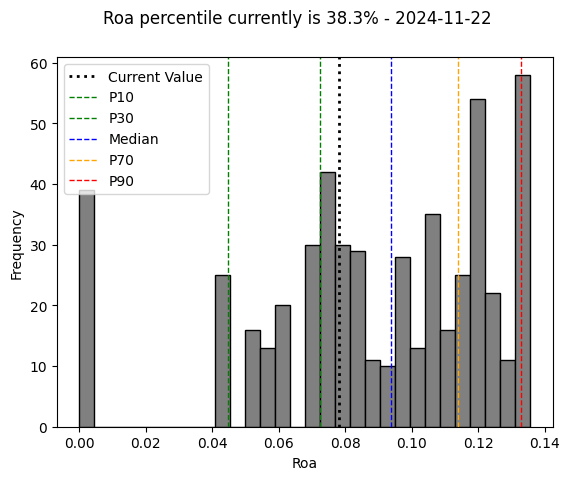

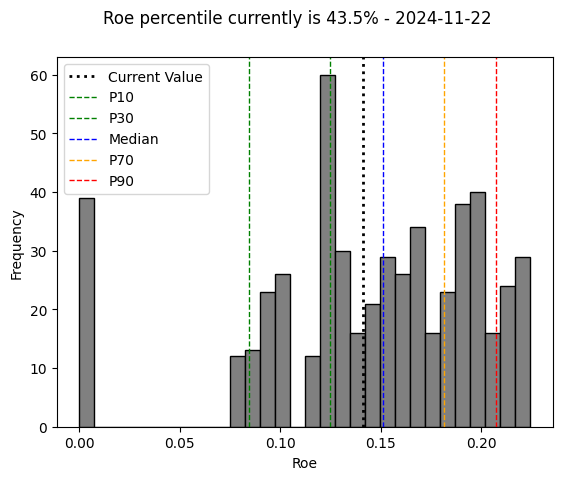

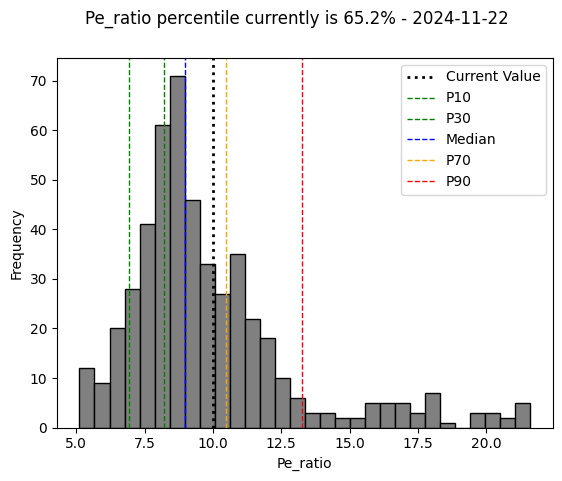

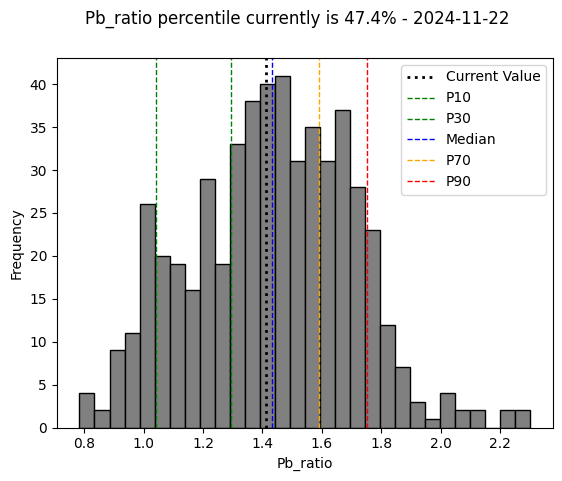

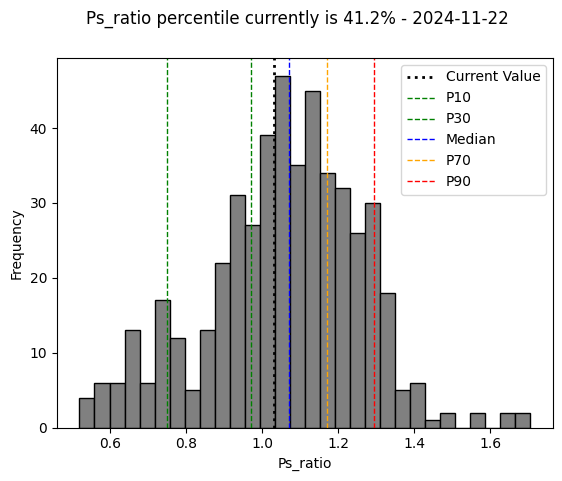

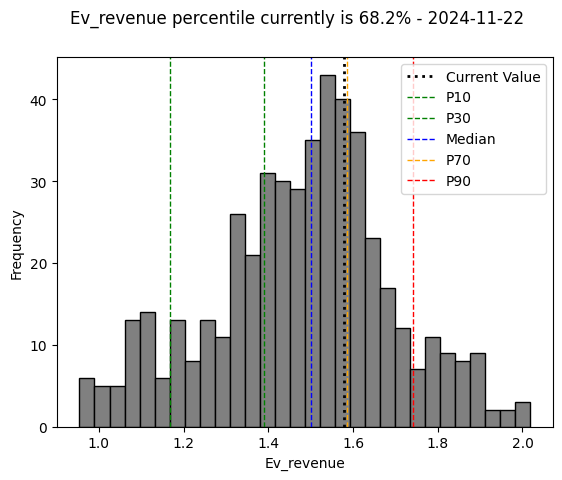

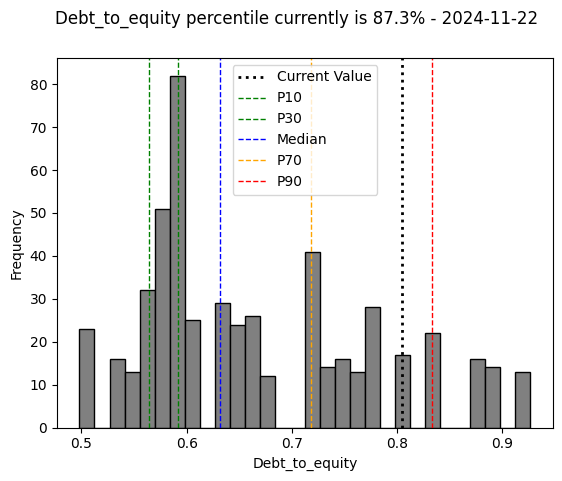

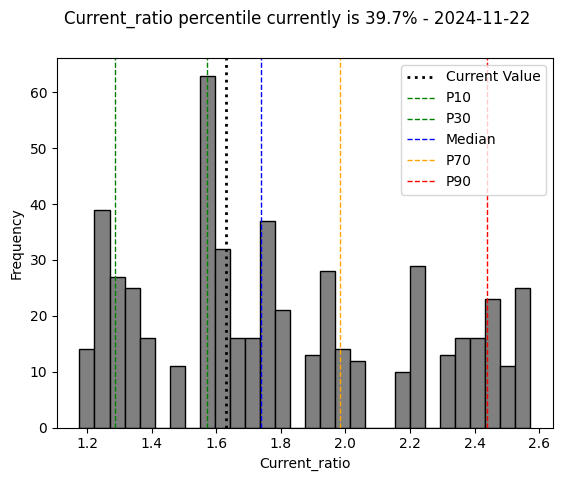

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.991290,-0.742228,0.403206,0.244430,-0.076342,-0.656903,0.624635
roe,0.991290,1.000000,-0.715689,0.442445,0.263409,-0.028960,-0.560661,0.605917
pe_ratio,-0.742228,-0.715689,1.000000,0.299796,0.348755,0.592765,0.603145,-0.222716
pb_ratio,0.403206,0.442445,0.299796,1.000000,0.923318,0.834572,0.027498,0.558603
ps_ratio,0.244430,0.263409,0.348755,0.923318,1.000000,0.916667,-0.036950,0.582834
ev_revenue,-0.076342,-0.028960,0.592765,0.834572,0.916667,1.000000,0.285564,0.288179
debt_to_equity,-0.656903,-0.560661,0.603145,0.027498,-0.036950,0.285564,1.000000,-0.501502
current_ratio,0.624635,0.605917,-0.222716,0.558603,0.582834,0.288179,-0.501502,1.000000


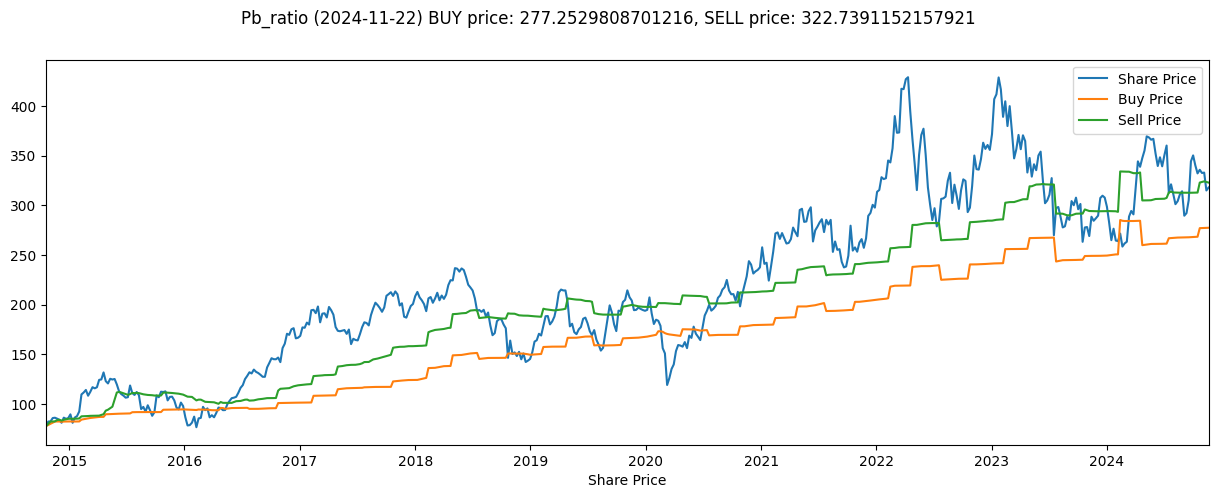

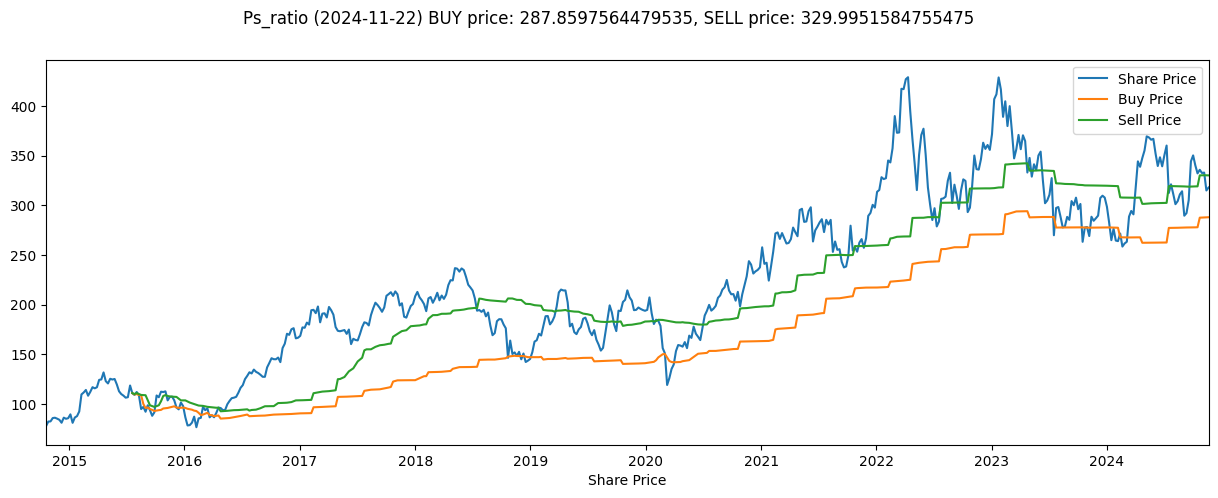

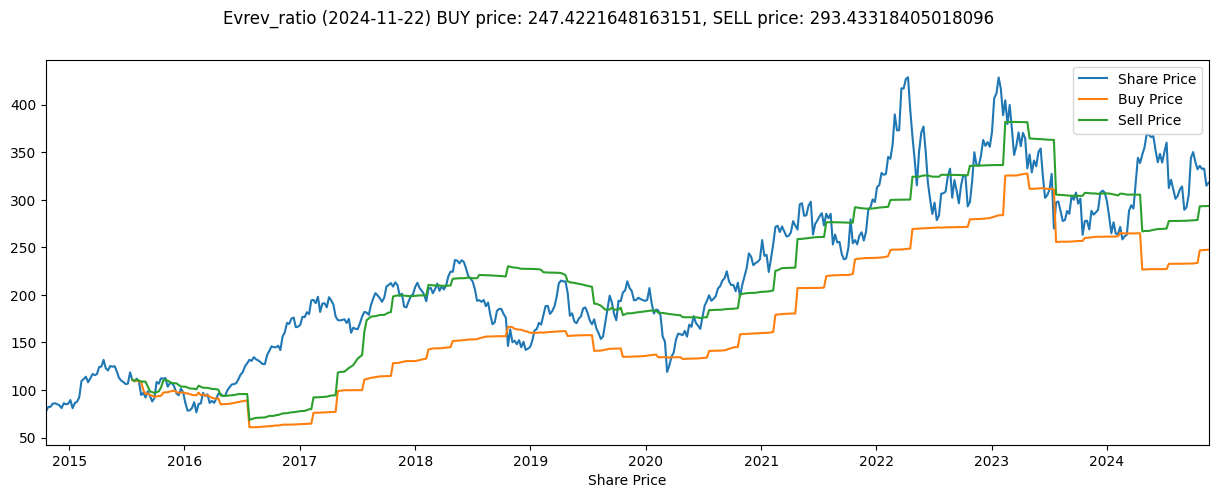

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.25,
    max_pct=0.5,
    owned_shares=owned_shares
)